In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

# Load the Excel file
xls = pd.ExcelFile("Buildings_el.xlsx")
electricity_df = xls.parse('Electricity kWh')
weather_df = xls.parse('Weather archive')


In [3]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [4]:
new_header = electricity_df.iloc[0]
electricity_df_clean = electricity_df[1:].copy()
electricity_df_clean.columns = new_header
electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)
electricity_df_clean["Timestamp"] = pd.to_datetime(electricity_df_clean["Timestamp"])
electricity_df_clean.set_index("Timestamp", inplace=True)
electricity_df_clean = electricity_df_clean.apply(pd.to_numeric, errors='coerce')

# Reshape to long format
electricity_long = electricity_df_clean.reset_index().melt(id_vars="Timestamp", 
                                                           var_name="Building", 
                                                           value_name="kWh")

/tmp/ipykernel_7752/3196237174.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)


In [5]:
# --- 4. Clean Weather Data ---
weather_df.columns = weather_df.iloc[1]
weather_df = weather_df[2:].copy()
weather_df.rename(columns={"Local time in Tallinn ": "Timestamp"}, inplace=True)
weather_df["Timestamp"] = pd.to_datetime(weather_df["Timestamp"], dayfirst=True)
weather_df = weather_df.rename(columns={"T": "Temperature", "U": "Humidity", "Ff": "Wind", "P0": "Pressure"})
for col in ["Temperature", "Humidity", "Wind", "Pressure"]:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')
weather_df = weather_df[["Timestamp", "Temperature", "Humidity", "Wind", "Pressure"]].dropna()
weather_df = weather_df.set_index("Timestamp").resample("h").mean()

In [6]:
set(electricity_long['Building'])

{'D04',
 'ICT',
 'LIB',
 'MEK',
 'OBS',
 'S01',
 'SOC',
 'TEG',
 'U05, U04, U04B, GEO',
 'U06, U06A, U05B'}

In [7]:
#create a different dataset for each building
building_dfs = {}
for building in electricity_long['Building'].unique():
    building_dfs[building] = electricity_long[electricity_long['Building'] == building].copy()
    building_dfs[building].set_index('Timestamp', inplace=True)
    building_dfs[building].drop(columns=['Building'], inplace=True)
    building_dfs[building].rename(columns={'kWh': 'Electricity kWh'}, inplace=True)

    # Merge with weather data
    building_dfs[building] = building_dfs[building].merge(weather_df, left_index=True, right_index=True, how='inner')
    building_dfs[building]["Hour"] = building_dfs[building].index.hour
    building_dfs[building]["DayOfWeek"] = building_dfs[building].index.dayofweek
    building_dfs[building]["Month"] = building_dfs[building].index.month
    building_dfs[building]["IsWeekend"] = (building_dfs[building]["DayOfWeek"] >= 5).astype(int)
    
    building_dfs[building].reset_index(inplace=True)

In [8]:
building_dfs['D04'].head()

,Timestamp,Electricity kWh,Temperature,Humidity,Wind,Pressure,Hour,DayOfWeek,Month,IsWeekend
0,2023-01-01 00:00:00,10.6,5.0,93.0,5.0,742.60,0,6,1,1
1,2023-01-01 01:00:00,12.3,5.0,90.0,5.0,742.95,1,6,1,1
2,2023-01-01 02:00:00,12.0,4.5,93.0,6.0,743.30,2,6,1,1
3,2023-01-01 03:00:00,10.9,4.0,93.0,6.0,744.10,3,6,1,1
4,2023-01-01 04:00:00,11.5,3.5,90.0,5.5,744.10,4,6,1,1


(7007,) (1752,)
(7007,) (1752,)
(7007,) (1752,)
(7007,) (1752,)
(7007,) (1752,)
(7007,) (1752,)
(7007,) (1752,)
(7007,) (1752,)
(7007,) (1752,)
(7007,) (1752,)


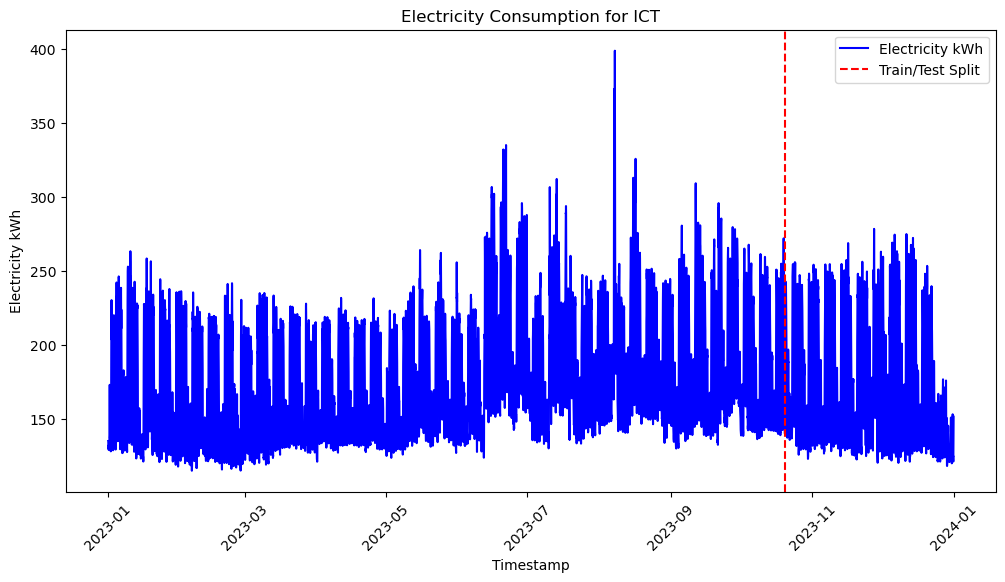

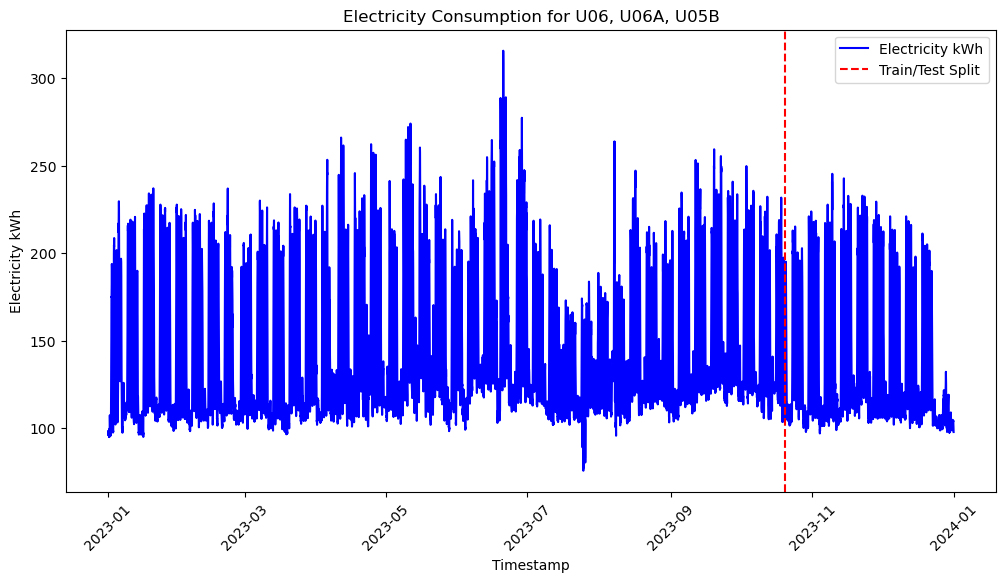

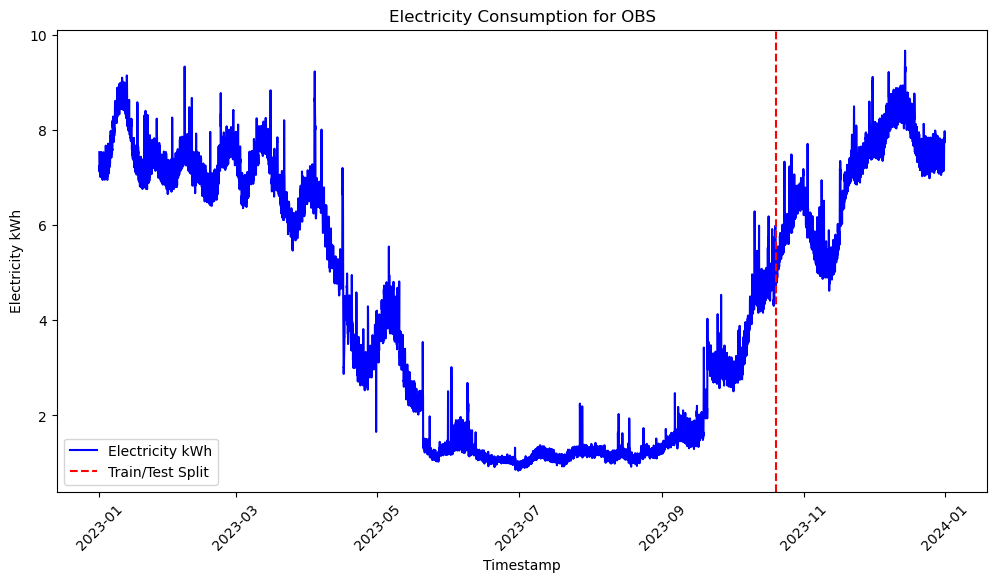

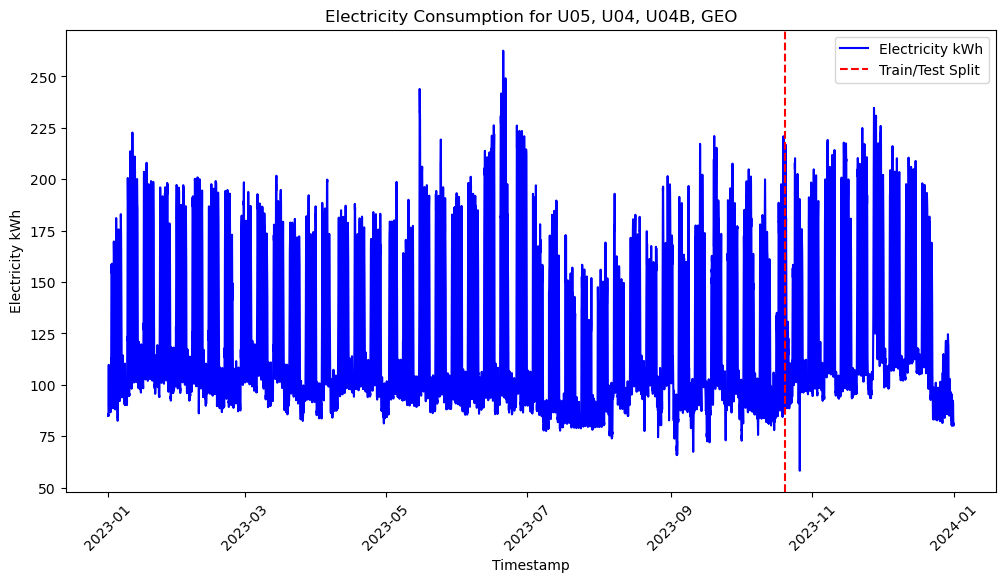

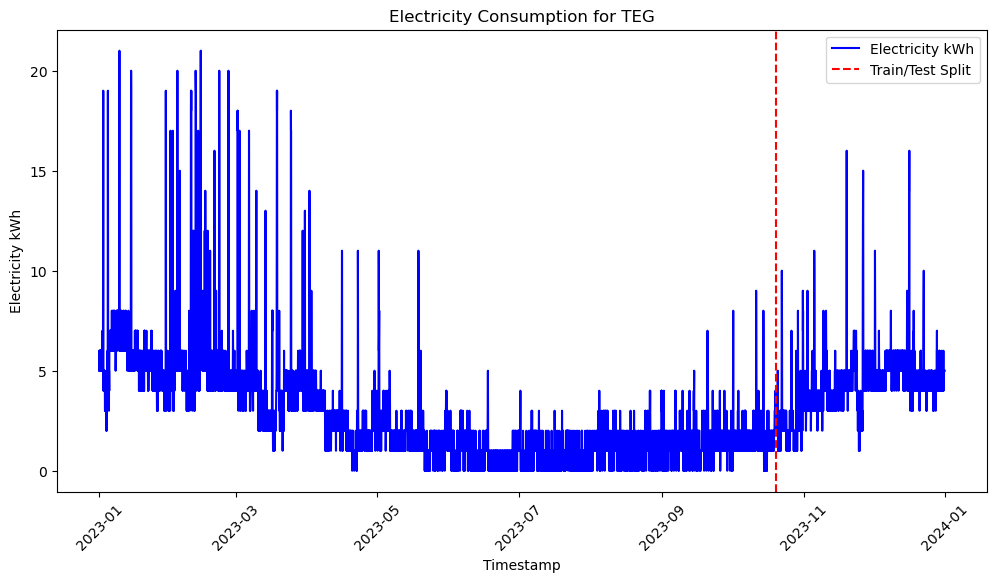

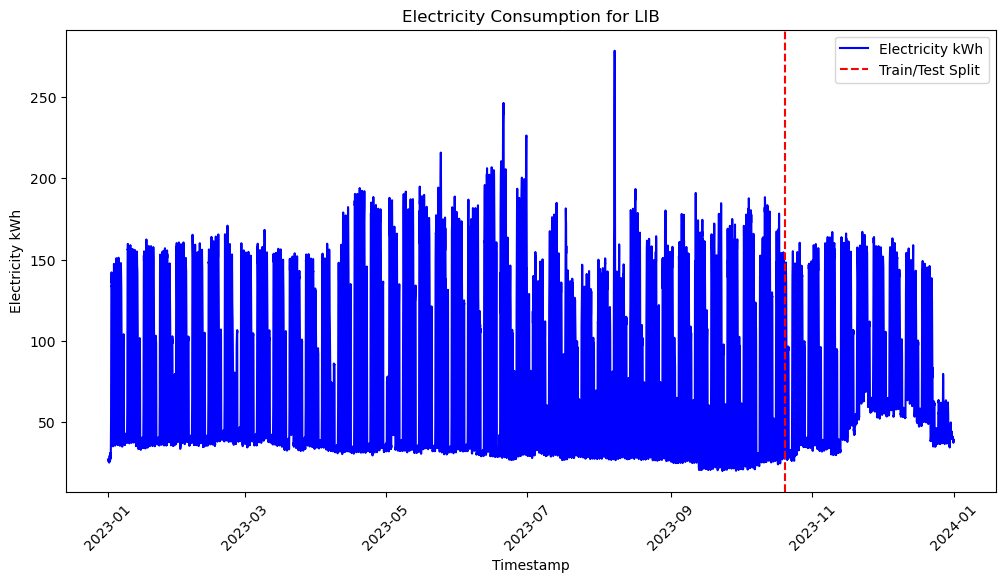

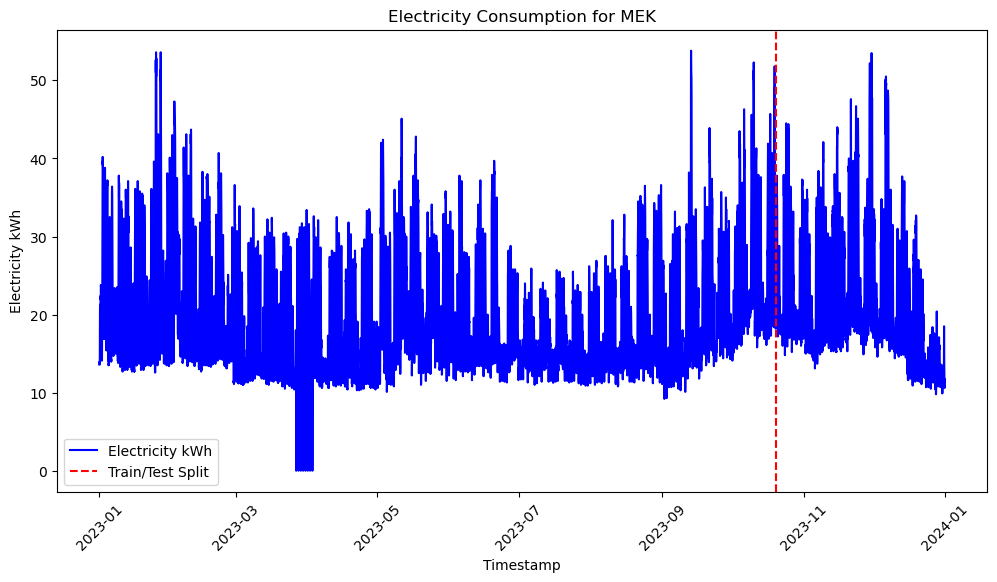

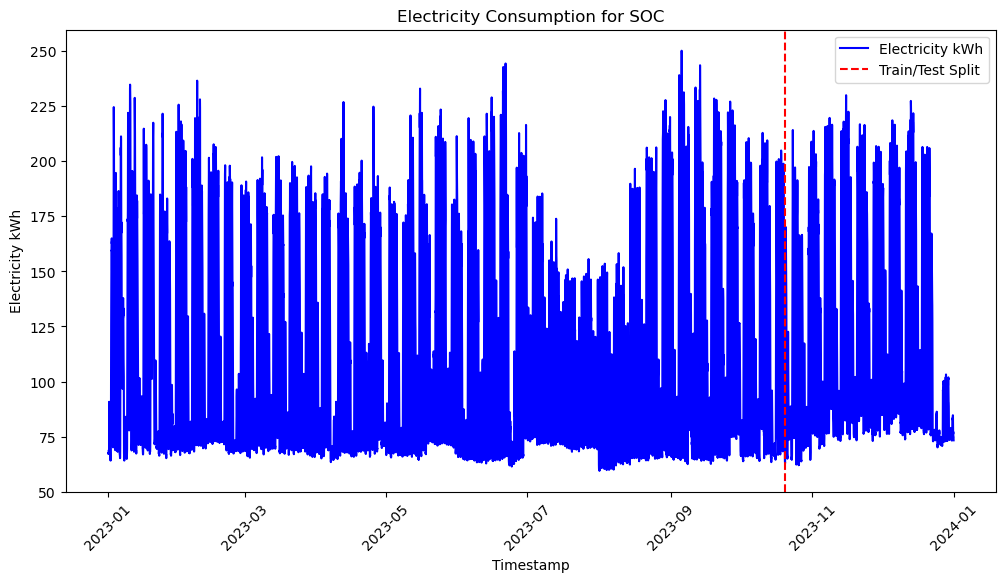

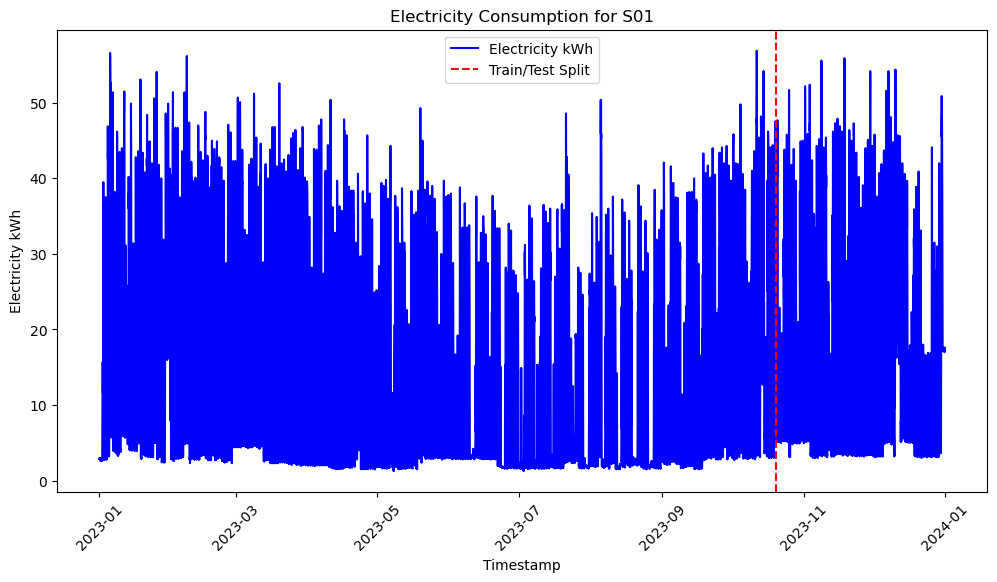

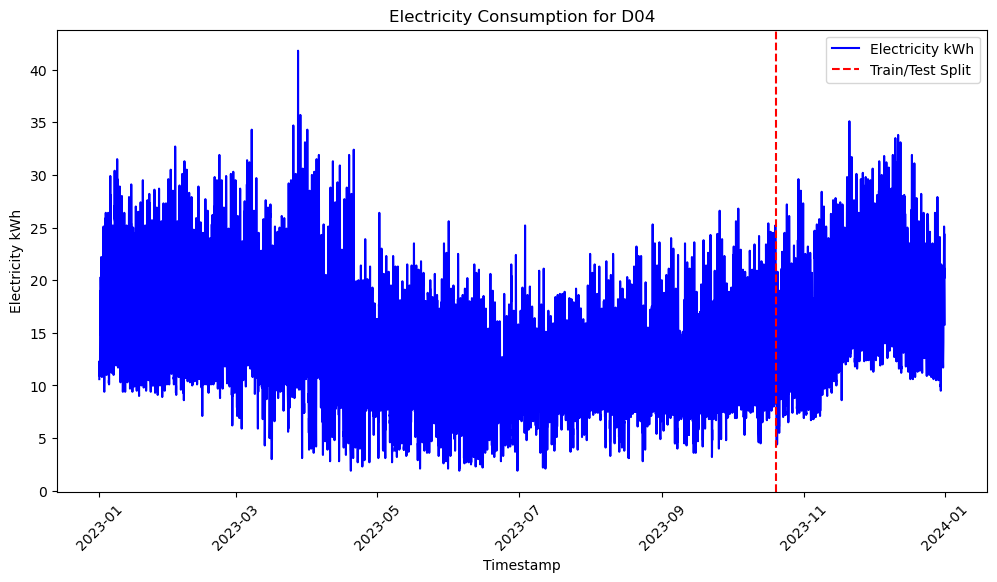

In [9]:
for building, df in building_dfs.items():
    # Create a new figure for each building
    size = int(len(df) * 0.8)
    train, test = df[:size]['Electricity kWh'], df[size:]['Electricity kWh']
    print(train.shape, test.shape)
    plt.figure(figsize=(12, 6))
    plt.plot(df['Timestamp'], df['Electricity kWh'], label='Electricity kWh', color='blue')
    plt.axvline(x=df['Timestamp'][size], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f"Electricity Consumption for {building}")
    plt.xlabel("Timestamp")
    plt.ylabel("Electricity kWh")
    plt.legend()
    plt.xticks(rotation=45)

## Chekcing stationarity for building:  ICT
ADF Statistic: -15.759884
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


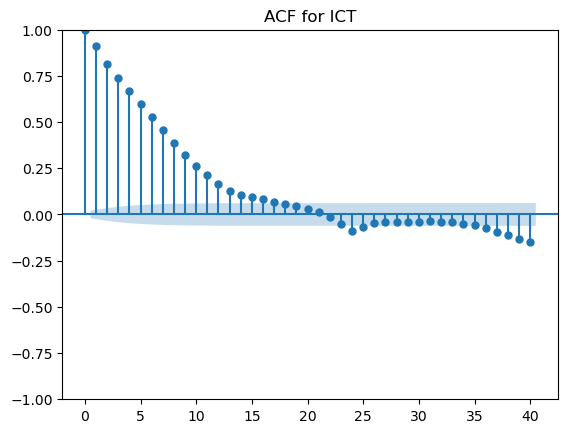

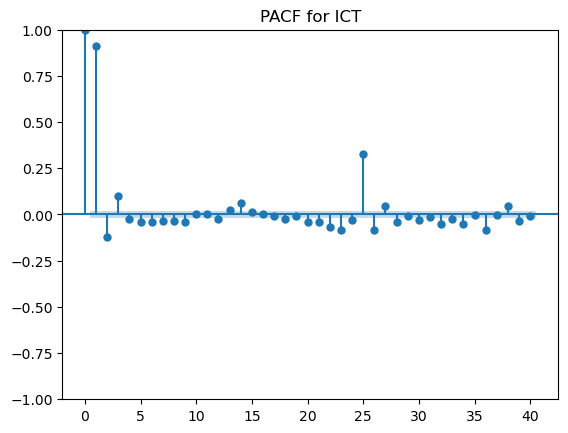

## Chekcing stationarity for building:  U06, U06A, U05B
ADF Statistic: -15.714158
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


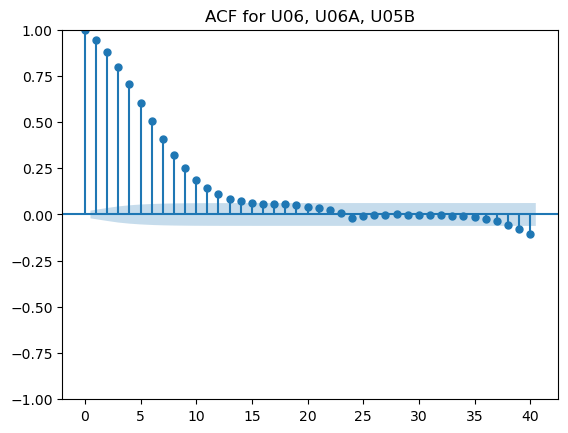

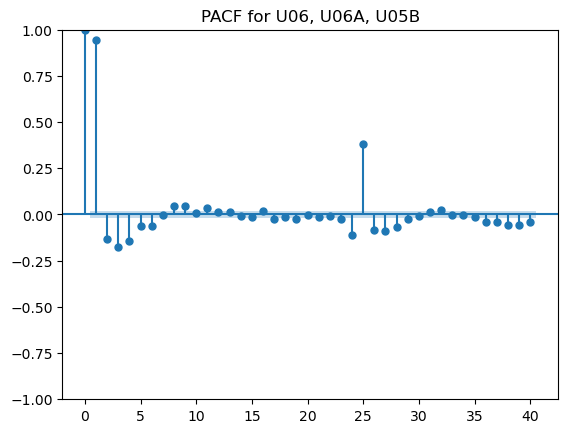

## Chekcing stationarity for building:  OBS
ADF Statistic: -10.141090
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


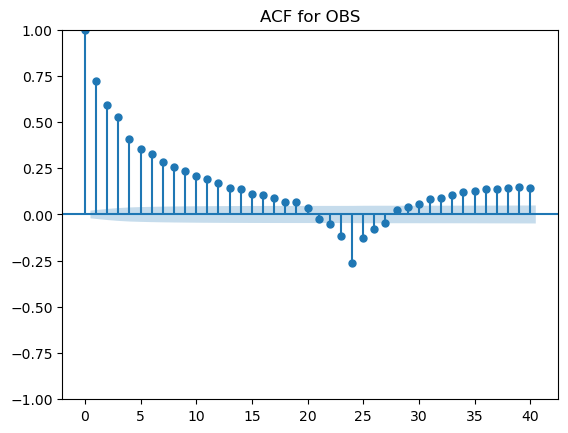

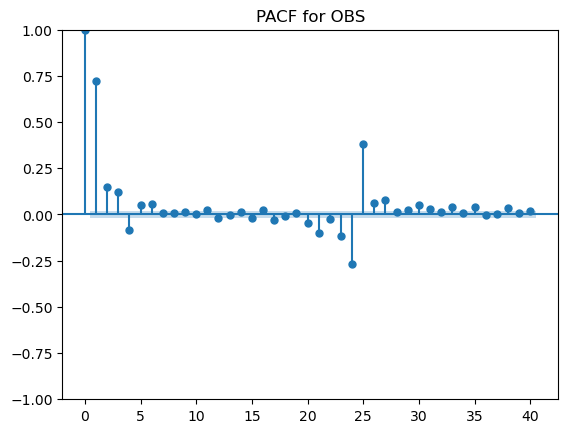

## Chekcing stationarity for building:  U05, U04, U04B, GEO
ADF Statistic: -14.941081
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


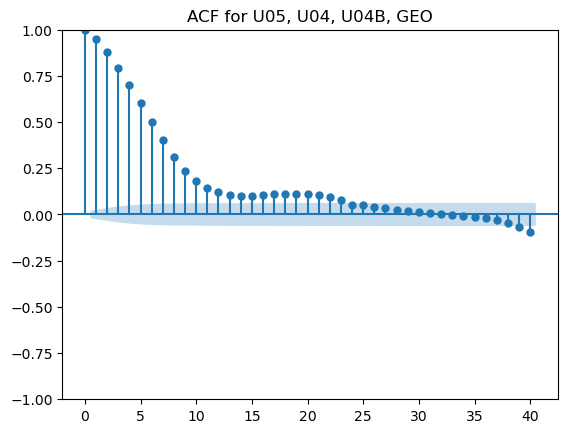

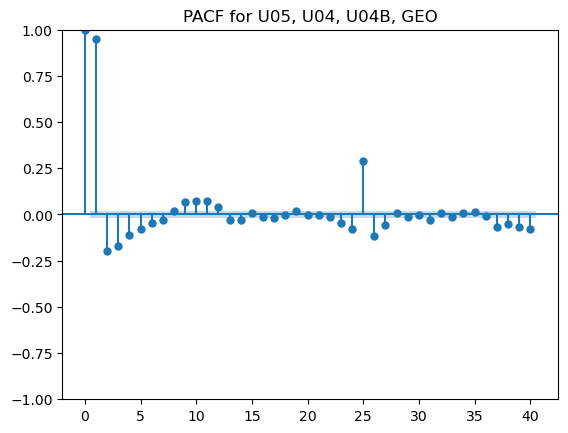

## Chekcing stationarity for building:  TEG
ADF Statistic: -22.469664
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


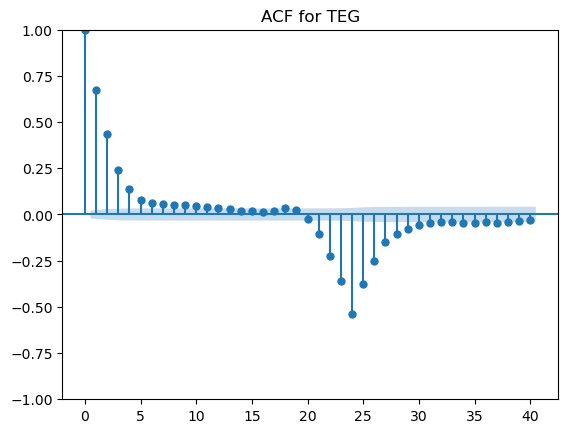

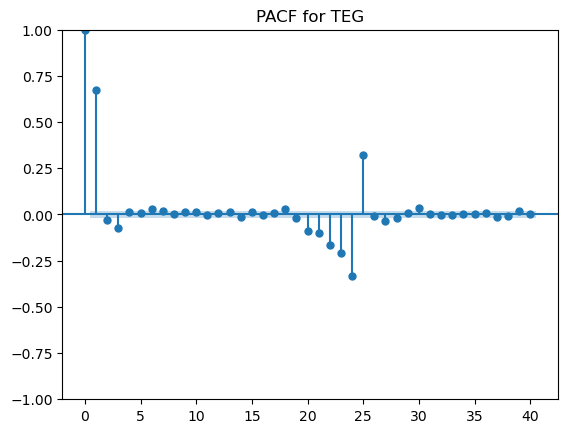

## Chekcing stationarity for building:  LIB
ADF Statistic: -17.143354
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


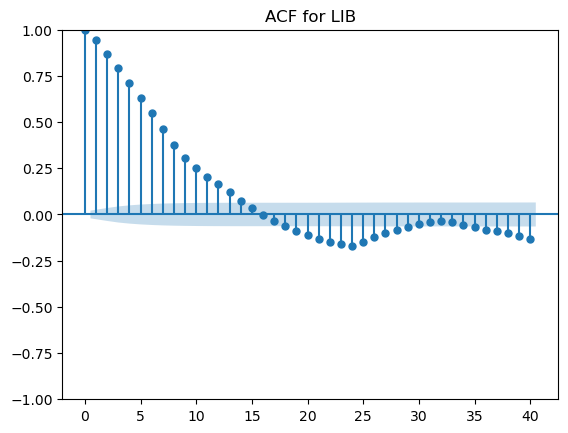

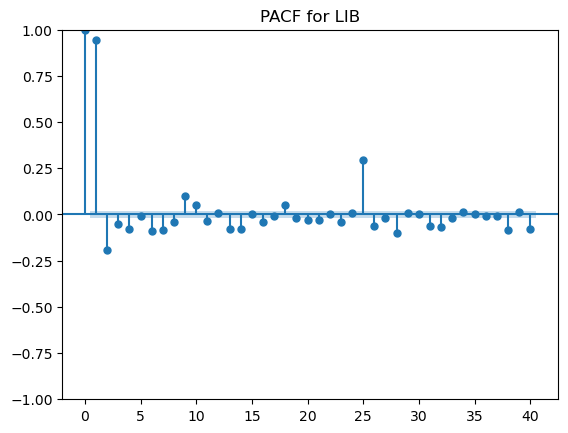

## Chekcing stationarity for building:  MEK
ADF Statistic: -14.398936
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


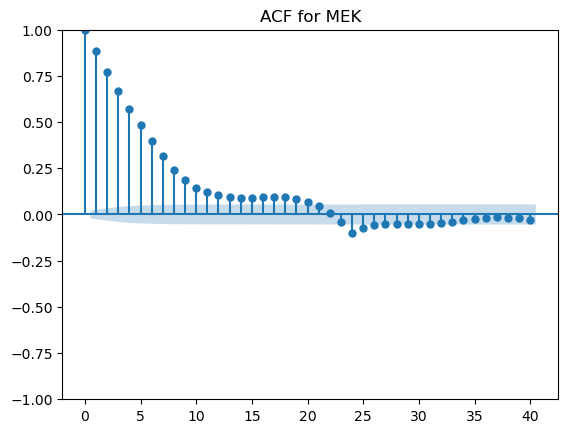

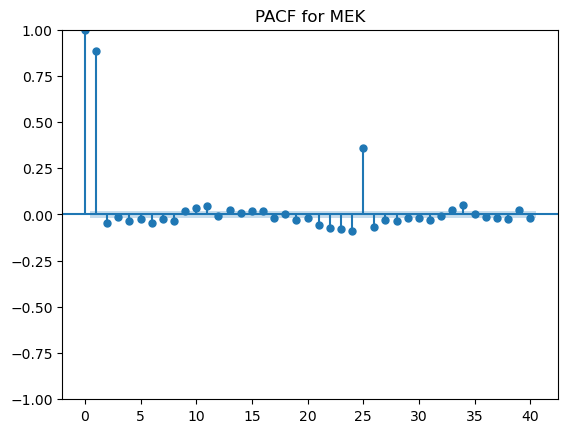

## Chekcing stationarity for building:  SOC
ADF Statistic: -16.753784
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


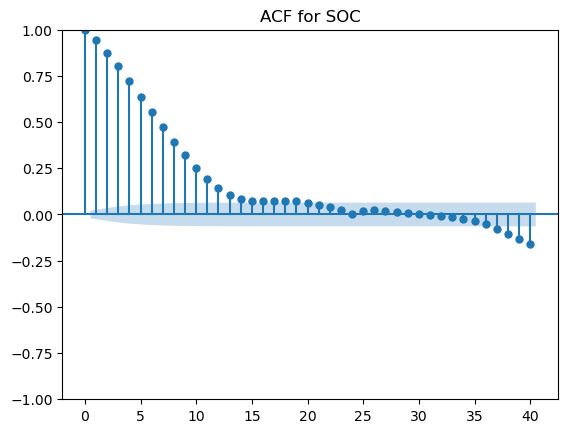

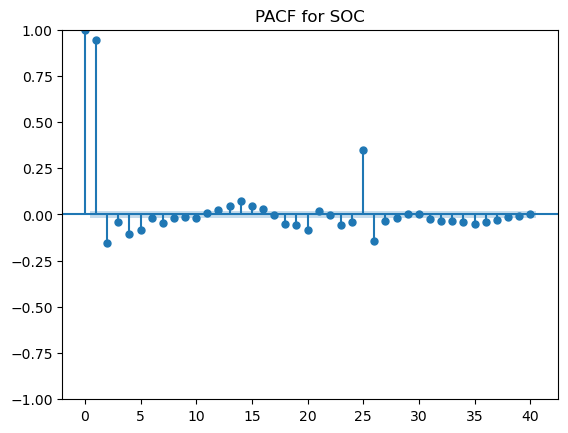

## Chekcing stationarity for building:  S01
ADF Statistic: -15.961245
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


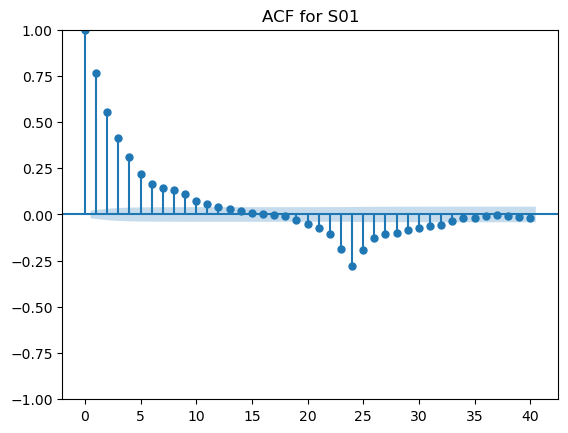

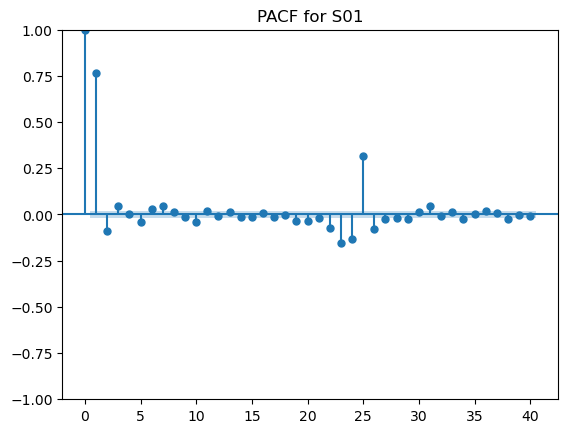

## Chekcing stationarity for building:  D04
ADF Statistic: -22.663313
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


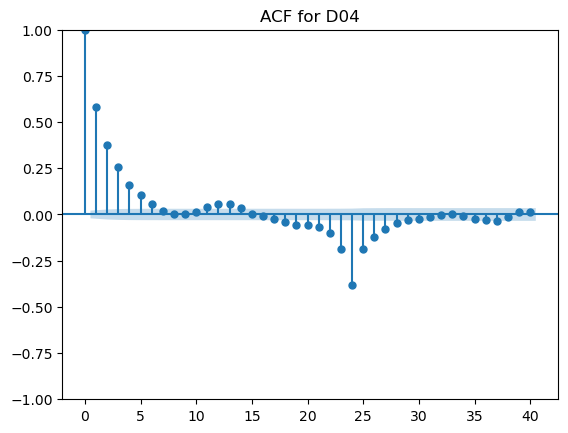

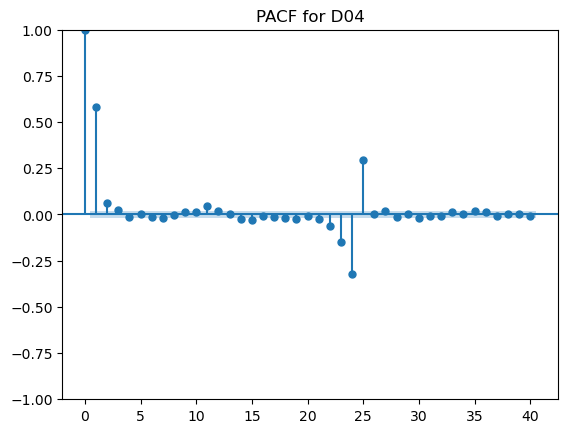

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for building, df in building_dfs.items():
    # size = int(len(df) * 0.8)
    # train, test = df[:size]['Electricity kWh'], df[size:]['Electricity kWh']
    print("## Chekcing stationarity for building: ", building)
    
    ## apply seasonal differencing of order 24
    df_kWh_seasonal = df['Electricity kWh'].diff(24).dropna()
    
    check_stationarity(df_kWh_seasonal)

    _ = plot_acf(df_kWh_seasonal.values, title=f"ACF for {building}")

    _ = plot_pacf(df_kWh_seasonal.values, title=f"PACF for {building}")
    plt.show()
    

In [11]:
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

feature_columns = ['Temperature', 'Humidity', 'Wind', 'Pressure', 'IsWeekend']

building_models = {}

for building, df in reversed(list(building_dfs.items())):
    size = int(len(df) * 0.8)
    # impute missing values for feature columns by linear interpolation
    df[feature_columns] = df[feature_columns].interpolate(method='linear')
    df[feature_columns] = df[feature_columns].fillna(method='ffill')
    df[feature_columns] = df[feature_columns].fillna(method='bfill')
    
    train, test = df[:size], df[size:]
    
    X_train = train[feature_columns]
    y_train = train['Electricity kWh']
    
    print(f"Training SARIMAX model for {building}...")
    model = SARIMAX(y_train, 
                    exog=X_train, 
                    order=(1, 0, 1), 
                    seasonal_order=(1, 1, 1, 24),
                    maxiter=10,)

    # Fit the model    
    model_fit = model.fit()
    building_models[building] = model_fit

    

/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for D04...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19620D+00    |proj g|=  1.14997D-01


 This problem is unconstrained.



At iterate    5    f=  2.10843D+00    |proj g|=  5.59211D-02

At iterate   10    f=  2.08656D+00    |proj g|=  3.51247D-03

At iterate   15    f=  2.08639D+00    |proj g|=  2.41186D-03

At iterate   20    f=  2.08635D+00    |proj g|=  3.15181D-03

At iterate   25    f=  2.08633D+00    |proj g|=  4.03986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     28     31      1     0     0   3.090D-05   2.086D+00
  F =   2.0863257226941401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for S01...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93540D+00    |proj g|=  1.00091D-01

At iterate    5    f=  2.81415D+00    |proj g|=  1.33085D-02

At iterate   10    f=  2.81246D+00    |proj g|=  1.77926D-03

At iterate   15    f=  2.81168D+00    |proj g|=  5.69181D-03

At iterate   20    f=  2.81130D+00    |proj g|=  1.30061D-03

At iterate   25    f=  2.81129D+00    |proj g|=  2.33366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     26     27      1     0     0   

/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for SOC...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84039D+00    |proj g|=  1.49420D-01


 This problem is unconstrained.



At iterate    5    f=  3.73627D+00    |proj g|=  6.63202D-02

At iterate   10    f=  3.69794D+00    |proj g|=  7.17346D-03

At iterate   15    f=  3.69034D+00    |proj g|=  6.34951D-03

At iterate   20    f=  3.66186D+00    |proj g|=  2.41222D-02

At iterate   25    f=  3.64176D+00    |proj g|=  4.66718D-02

At iterate   30    f=  3.61554D+00    |proj g|=  3.61692D-02

At iterate   35    f=  3.60711D+00    |proj g|=  2.14705D-02

At iterate   40    f=  3.60558D+00    |proj g|=  1.75499D-03

At iterate   45    f=  3.60509D+00    |proj g|=  1.46186D-03

At iterate   50    f=  3.60498D+00    |proj g|=  4.96877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.1

Training SARIMAX model for MEK...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25754D+00    |proj g|=  1.04939D-01


 This problem is unconstrained.



At iterate    5    f=  2.14289D+00    |proj g|=  7.69694D-02

At iterate   10    f=  2.12223D+00    |proj g|=  1.76322D-02

At iterate   15    f=  2.11485D+00    |proj g|=  6.11669D-03

At iterate   20    f=  2.10308D+00    |proj g|=  6.25733D-03

At iterate   25    f=  2.10282D+00    |proj g|=  4.35637D-03

At iterate   30    f=  2.10278D+00    |proj g|=  1.18984D-03

At iterate   35    f=  2.10278D+00    |proj g|=  2.13998D-04

At iterate   40    f=  2.10278D+00    |proj g|=  1.37256D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     40     47      1     0     0   1.373D-05   2.103D+00
  F =   2.10278097684

/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for LIB...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03395D+00    |proj g|=  8.66498D-02


 This problem is unconstrained.



At iterate    5    f=  3.90520D+00    |proj g|=  6.77195D-02

At iterate   10    f=  3.85651D+00    |proj g|=  8.09579D-03

At iterate   15    f=  3.84712D+00    |proj g|=  1.40395D-02

At iterate   20    f=  3.80468D+00    |proj g|=  1.82852D-02

At iterate   25    f=  3.75552D+00    |proj g|=  2.38723D-02

At iterate   30    f=  3.75266D+00    |proj g|=  2.06041D-03

At iterate   35    f=  3.75153D+00    |proj g|=  4.21056D-03

At iterate   40    f=  3.75140D+00    |proj g|=  3.65100D-04

At iterate   45    f=  3.75139D+00    |proj g|=  4.96335D-04


/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.75138D+00    |proj g|=  8.70493D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     56      1     0     0   8.705D-05   3.751D+00
  F =   3.7513802759244044     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for TEG...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68903D+00    |proj g|=  2.30132D-01

At iterate    5    f=  1.61541D+00    |proj g|=  2.41940D-01

At iterate   10    f=  1.55690D+00    |proj g|=  2.34963D-01

At iterate   15    f=  1.54898D+00    |proj g|=  7.75196D-03

At iterate   20    f=  1.54897D+00    |proj g|=  1.00296D-03

At iterate   25    f=  1.54896D+00    |proj g|=  7.57885D-04

At iterate   30    f=  1.54895D+00    |proj g|=  6.84617D-04

At iterate   35    f=  1.54895D+00    |proj g|=  3.88237D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for U05, U04, U04B, GEO...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68913D+00    |proj g|=  1.54541D-01


 This problem is unconstrained.



At iterate    5    f=  3.56428D+00    |proj g|=  7.11377D-02

At iterate   10    f=  3.52365D+00    |proj g|=  1.91052D-02

At iterate   15    f=  3.51415D+00    |proj g|=  6.38454D-02

At iterate   20    f=  3.45101D+00    |proj g|=  2.98744D-02

At iterate   25    f=  3.44289D+00    |proj g|=  5.06344D-02

At iterate   30    f=  3.42546D+00    |proj g|=  4.44346D-03

At iterate   35    f=  3.42360D+00    |proj g|=  2.49545D-03

At iterate   40    f=  3.42269D+00    |proj g|=  3.88986D-03

At iterate   45    f=  3.41998D+00    |proj g|=  1.66494D-02


/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.41691D+00    |proj g|=  4.41523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     54      1     0     0   4.415D-03   3.417D+00
  F =   3.4169089719527008     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for OBS...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41643D-01    |proj g|=  1.31416D+00

At iterate    5    f= -2.69618D-01    |proj g|=  1.12765D-01

At iterate   10    f= -2.85330D-01    |proj g|=  2.00562D-01

At iterate   15    f= -2.87489D-01    |proj g|=  3.74444D-01

At iterate   20    f= -3.02074D-01    |proj g|=  9.74221D-01

At iterate   25    f= -3.09817D-01    |proj g|=  1.44633D-01

At iterate   30    f= -3.31485D-01    |proj g|=  6.99028D-01

At iterate   35    f= -3.38158D-01    |proj g|=  7.95062D-02

At iterate   40    f= -3.42352D-01    |proj g|=  1.94216D-02

At iterate   45    f= -3.44578D-01    |proj g|=  4.52408D-01


/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.47752D-01    |proj g|=  4.57896D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   4.579D-02  -3.478D-01
  F = -0.34775200170382553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for U06, U06A, U05B...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73807D+00    |proj g|=  1.48453D-01


 This problem is unconstrained.



At iterate    5    f=  3.61795D+00    |proj g|=  4.30235D-02

At iterate   10    f=  3.56828D+00    |proj g|=  4.99030D-03

At iterate   15    f=  3.56144D+00    |proj g|=  2.70705D-02

At iterate   20    f=  3.55573D+00    |proj g|=  3.26374D-02

At iterate   25    f=  3.49885D+00    |proj g|=  8.31328D-03

At iterate   30    f=  3.48891D+00    |proj g|=  2.70187D-02

At iterate   35    f=  3.48640D+00    |proj g|=  1.74161D-02

At iterate   40    f=  3.48286D+00    |proj g|=  1.50258D-02

At iterate   45    f=  3.47806D+00    |proj g|=  2.33923D-02


/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.47740D+00    |proj g|=  2.50770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   2.508D-03   3.477D+00
  F =   3.4774031464128550     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/tmp/ipykernel_7752/4129449946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='ffill')
/tmp/ipykernel_7752/4129449946.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_columns] = df[feature_columns].fillna(method='bfill')
/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Training SARIMAX model for ICT...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77472D+00    |proj g|=  1.20229D-01

At iterate    5    f=  3.64115D+00    |proj g|=  2.83924D-02

At iterate   10    f=  3.60917D+00    |proj g|=  2.76435D-02

At iterate   15    f=  3.60532D+00    |proj g|=  4.11032D-03

At iterate   20    f=  3.59139D+00    |proj g|=  8.83746D-03

At iterate   25    f=  3.56459D+00    |proj g|=  5.35784D-02

At iterate   30    f=  3.55687D+00    |proj g|=  1.70048D-02

At iterate   35    f=  3.55148D+00    |proj g|=  1.63088D-02

At iterate   40    f=  3.54958D+00    |proj g|=  3.76687D-03

At iterate   45    f=  3.54943D+00    |proj g|=  1.18506D-03


/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.54942D+00    |proj g|=  7.50636D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     54      1     0     0   7.506D-04   3.549D+00
  F =   3.5494151085249834     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Model summary for D04:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -14618.884
Date:                            Fri, 09 May 2025   AIC                          29257.769
Time:                                    00:15:36   BIC                          29326.281
Sample:                                         0   HQIC                         29281.380
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.1428      0.018     -7.830      0.000      -0.179      -0.107
Humidity 

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


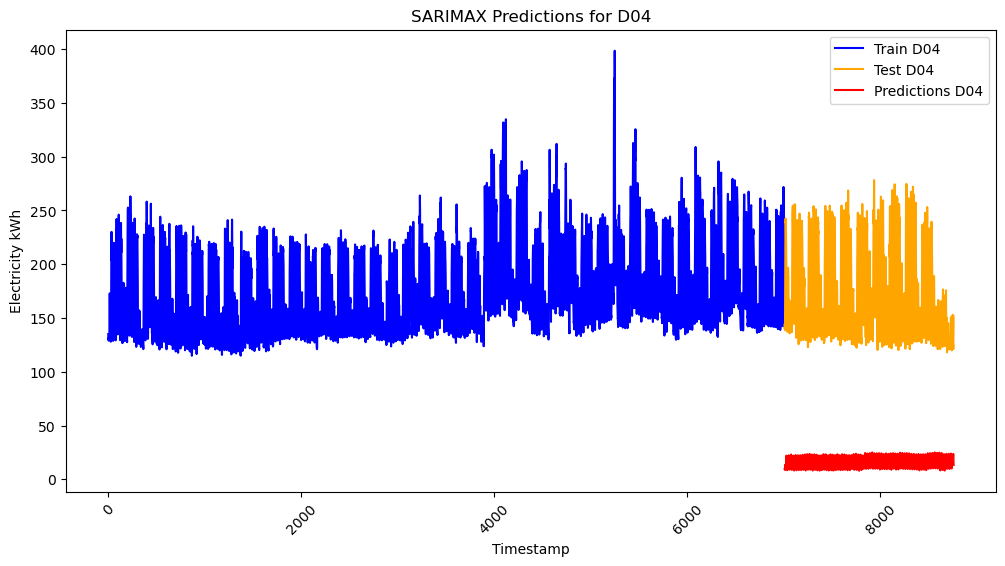

Model summary for S01:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -19698.680
Date:                            Fri, 09 May 2025   AIC                          39417.360
Time:                                    00:15:37   BIC                          39485.872
Sample:                                         0   HQIC                         39440.971
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.0606      0.055     -1.097      0.272      -0.169       0.048
Humidity 

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


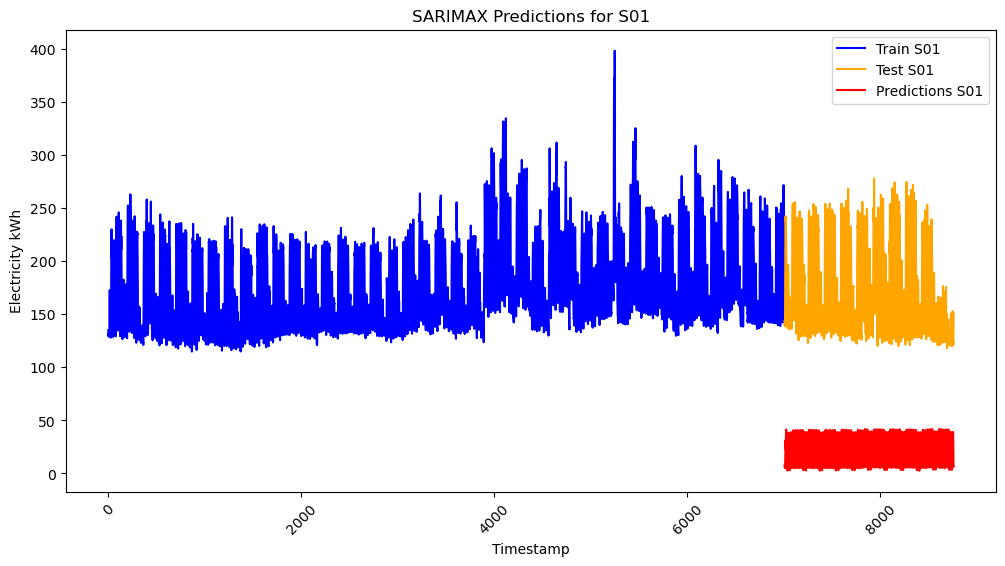

Model summary for SOC:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -25260.072
Date:                            Fri, 09 May 2025   AIC                          50540.143
Time:                                    00:15:37   BIC                          50608.656
Sample:                                         0   HQIC                         50563.754
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     0.2588      0.187      1.385      0.166      -0.107       0.625
Humidity 

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


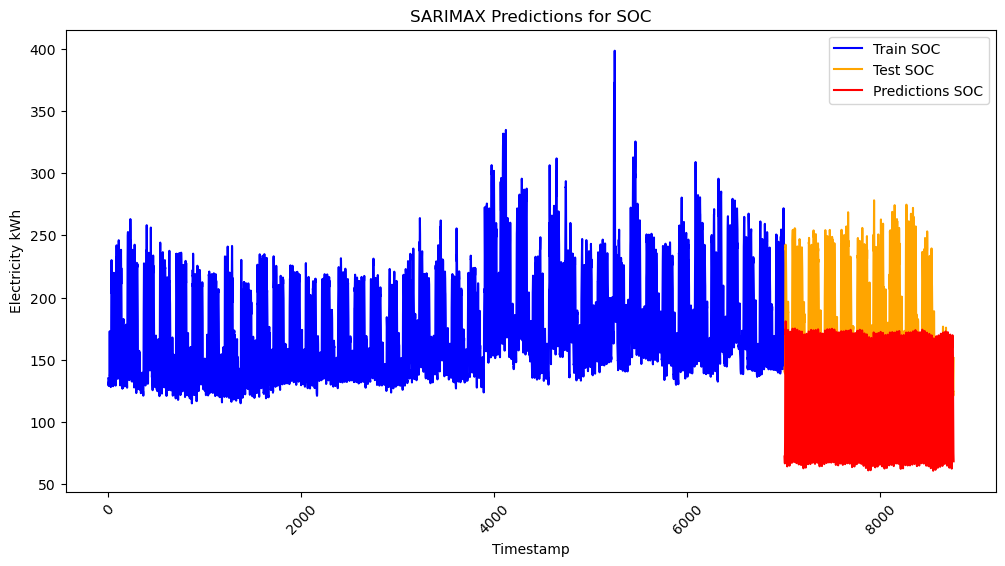

Model summary for MEK:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -14734.186
Date:                            Fri, 09 May 2025   AIC                          29488.373
Time:                                    00:15:37   BIC                          29556.885
Sample:                                         0   HQIC                         29511.984
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.0225      0.038     -0.598      0.550      -0.096       0.051
Humidity 

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


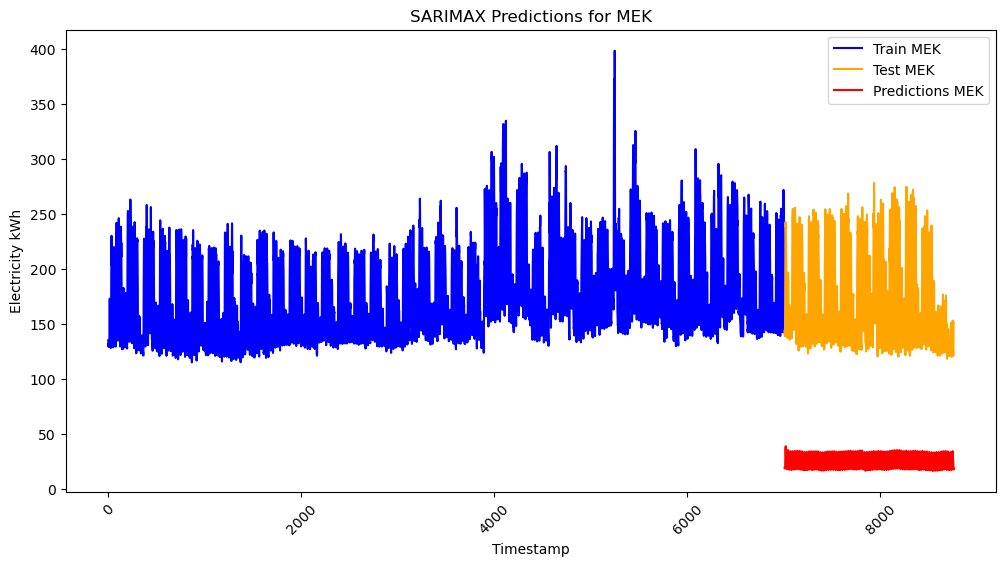

Model summary for LIB:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -26285.922
Date:                            Fri, 09 May 2025   AIC                          52591.843
Time:                                    00:15:38   BIC                          52660.356
Sample:                                         0   HQIC                         52615.454
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     0.7589      0.197      3.856      0.000       0.373       1.145
Humidity 

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


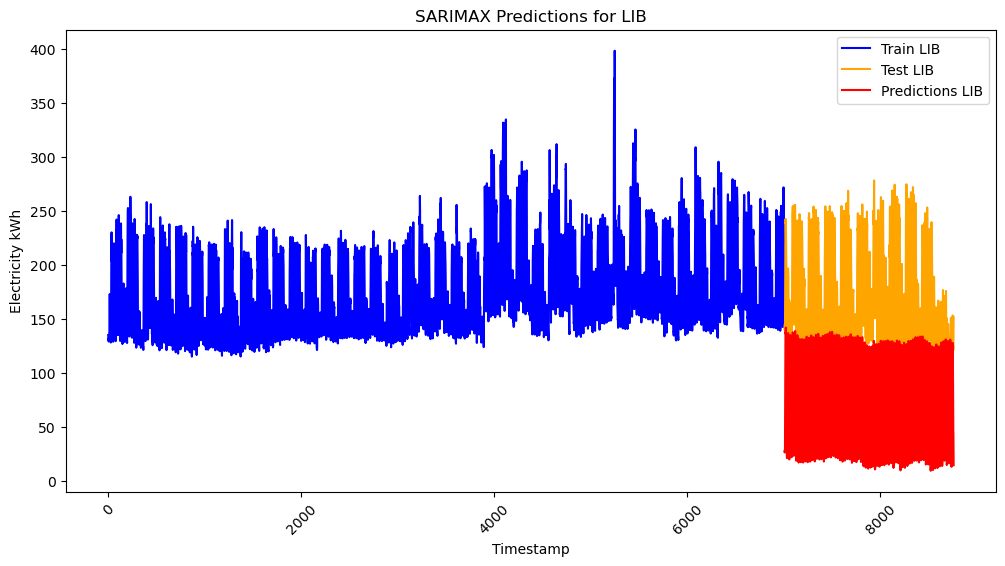

Model summary for TEG:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -10853.487
Date:                            Fri, 09 May 2025   AIC                          21726.974
Time:                                    00:15:38   BIC                          21795.486
Sample:                                         0   HQIC                         21750.585
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.0632      0.012     -5.303      0.000      -0.087      -0.040
Humidity 

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


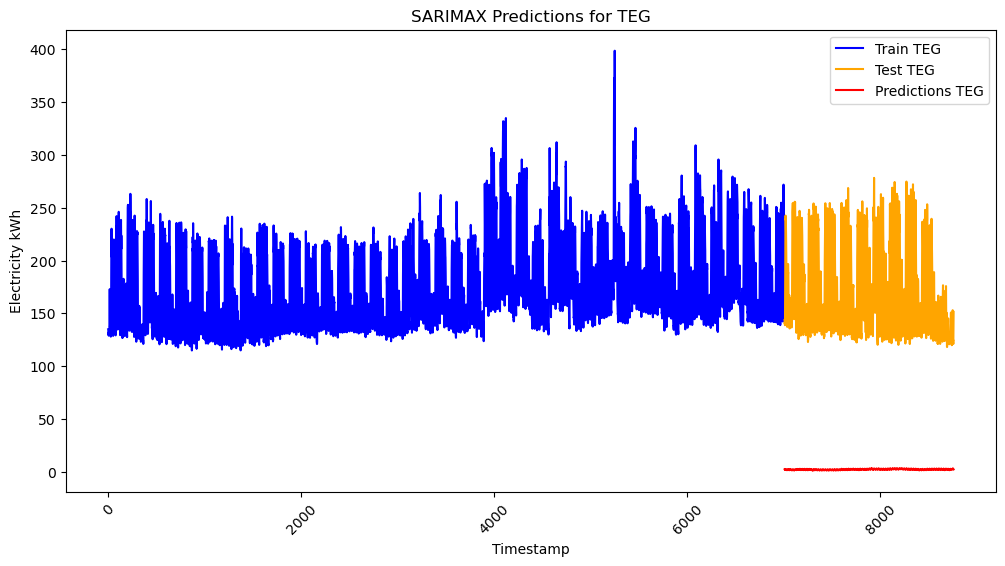

Model summary for U05, U04, U04B, GEO:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -23942.281
Date:                            Fri, 09 May 2025   AIC                          47904.562
Time:                                    00:15:38   BIC                          47973.075
Sample:                                         0   HQIC                         47928.173
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     0.5010      0.148      3.384      0.001       0.211      

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


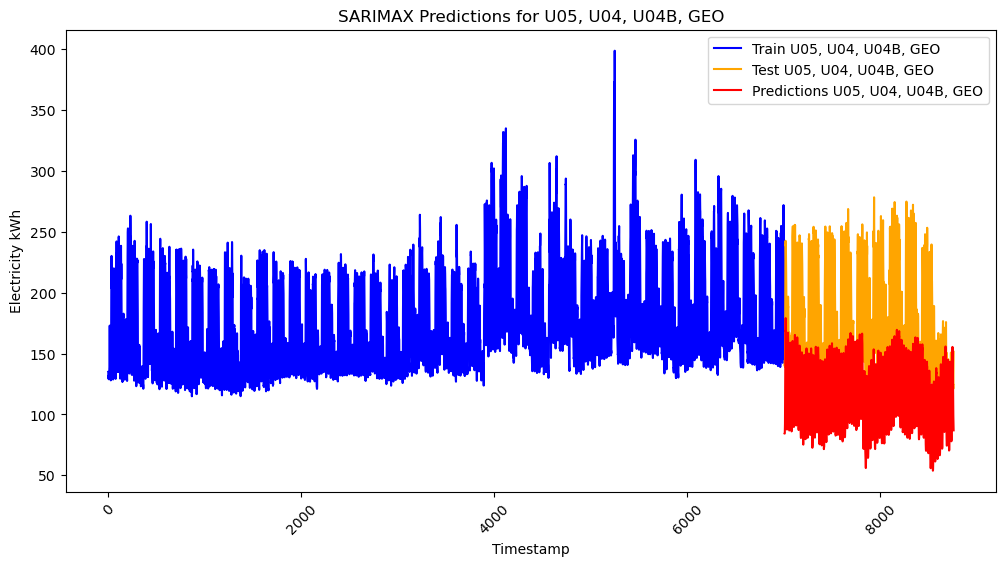

Model summary for OBS:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood                2436.698
Date:                            Fri, 09 May 2025   AIC                          -4853.397
Time:                                    00:15:39   BIC                          -4784.884
Sample:                                         0   HQIC                         -4829.785
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.0086      0.003     -2.534      0.011      -0.015      -0.002
Humidity 

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


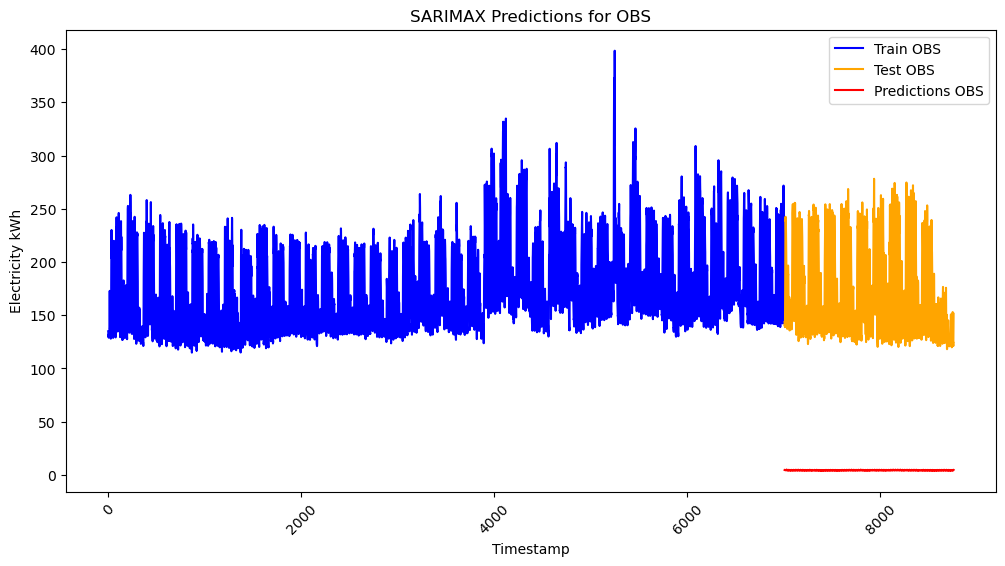

Model summary for U06, U06A, U05B:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -24366.164
Date:                            Fri, 09 May 2025   AIC                          48752.328
Time:                                    00:15:39   BIC                          48820.840
Sample:                                         0   HQIC                         48775.939
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     1.3207      0.153      8.613      0.000       1.020       1.6

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


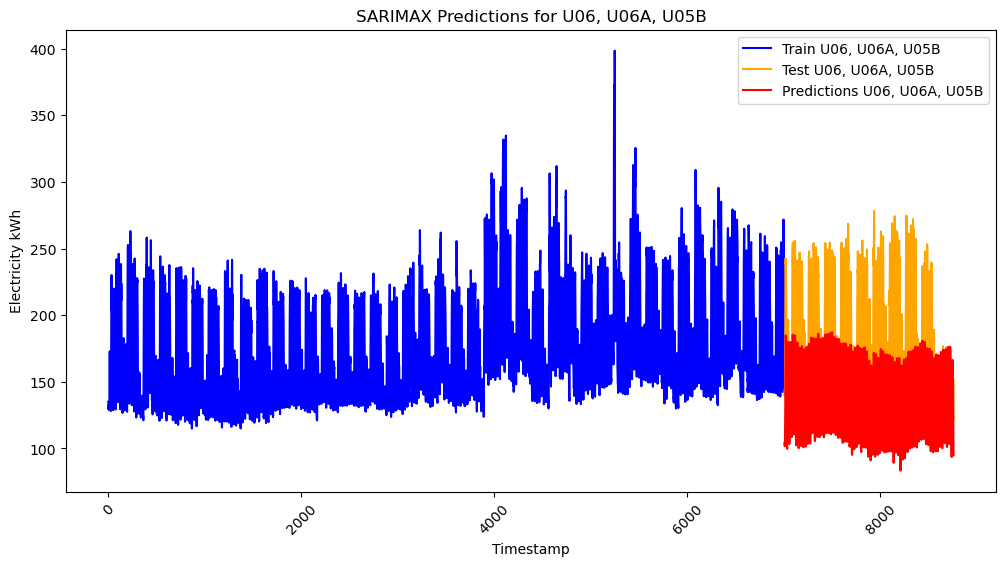

Model summary for ICT:
                                     SARIMAX Results                                      
Dep. Variable:                    Electricity kWh   No. Observations:                 7007
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -24870.752
Date:                            Fri, 09 May 2025   AIC                          49761.503
Time:                                    00:15:39   BIC                          49830.016
Sample:                                         0   HQIC                         49785.114
                                           - 7007                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     0.9613      0.157      6.135      0.000       0.654       1.268
Humidity 

/home/alex/miniconda3/envs/research-base/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


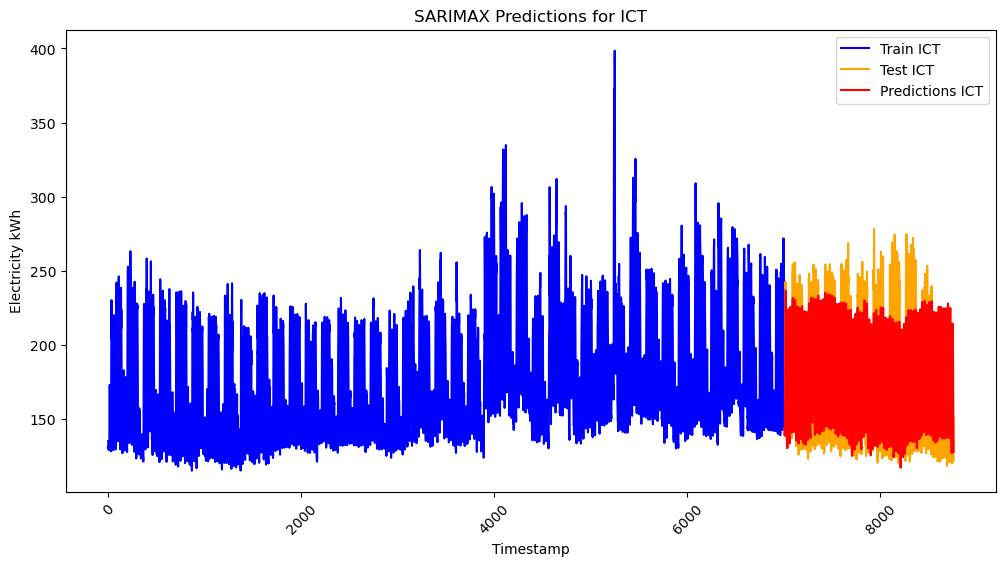

In [12]:
for building, model_fit in building_models.items():
    print(f"Model summary for {building}:")
    print(model_fit.summary())

    X_test = test[feature_columns]
    y_test = test['Electricity kWh']


    # # Plot the residuals
    # plt.figure(figsize=(12, 6))
    # plt.plot(model_fit.resid)
    # plt.title(f"Residuals for {building}")
    # plt.xlabel("Timestamp")
    # plt.ylabel("Residuals")
    # plt.axhline(0, color='red', linestyle='--')
    # plt.show()
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(train["Electricity kWh"], label=f'Train {building}', color='blue')
    plt.plot(test["Electricity kWh"], label=f'Test {building}', color='orange')
    plt.plot(predictions, label=f'Predictions {building}', color='red')
    plt.title(f"SARIMAX Predictions for {building}")
    plt.xlabel("Timestamp")
    plt.ylabel("Electricity kWh")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()